In [13]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.api.datasets import mnist


In [14]:
class ConvLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.1
        self.biases = np.zeros((out_channels, 1))
        self.last_input = None

    def forward(self, input):
        self.last_input = input
        in_channels, H, W = input.shape
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1
        output = np.zeros((self.out_channels, H_out, W_out))

        for oc in range(self.out_channels):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    patch = input[:, h_start:h_start + self.kernel_size, w_start:w_start + self.kernel_size]
                    output[oc, i, j] = np.sum(patch * self.weights[oc]) + self.biases[oc]
        return output

    def backward(self, d_out, learning_rate):
        input = self.last_input
        in_channels, H, W = input.shape
        H_out, W_out = d_out.shape[1], d_out.shape[2]

        d_input = np.zeros_like(input)
        d_weights = np.zeros_like(self.weights)
        d_biases = np.zeros_like(self.biases)

        for oc in range(self.out_channels):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    patch = input[:, h_start:h_start + self.kernel_size, w_start:w_start + self.kernel_size]
                    d_weights[oc] += d_out[oc, i, j] * patch
                    d_input[:, h_start:h_start + self.kernel_size, w_start:w_start + self.kernel_size] += (
                            d_out[oc, i, j] * self.weights[oc])
                    d_biases[oc] += d_out[oc, i, j]

        self.weights -= learning_rate * d_weights
        self.biases -= learning_rate * d_biases

        return d_input



In [15]:
class ReLULayer:
    def __init__(self):
        self.last_input = None

    def forward(self, input):
        self.last_input = input
        return np.maximum(0, input)

    def backward(self, d_out):
        d_input = d_out.copy()
        d_input[self.last_input <= 0] = 0
        return d_input

In [ ]:
class MPLayer:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.last_input = None
        self.mask = None

    def forward(self, input):
        self.last_input = input
        channels, H, W = input.shape
        H_out = (H - self.pool_size) // self.stride + 1
        W_out = (W - self.pool_size) // self.stride + 1
        output = np.zeros((channels, H_out, W_out))
        self.mask = {}

        for c in range(channels):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    window = input[c, h_start:h_start + self.pool_size, w_start:w_start + self.pool_size]
                    max_val = np.max(window)
                    output[c, i, j] = max_val
                    index = np.unravel_index(np.argmax(window), window.shape)
                    self.mask[(c, i, j)] = (h_start + index[0], w_start + index[1])
        return output

    def backward(self, d_out):
        d_input = np.zeros_like(self.last_input)
        channels_out, H_out, W_out = d_out.shape

        for c in range(channels_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_idx, w_idx = self.mask[(c, i, j)]
                    d_input[c, h_idx, w_idx] += d_out[c, i, j]
        return d_input


In [17]:
class FCLayer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size) * 0.1
        self.biases = np.zeros((output_size, 1))
        self.last_input = None

    def forward(self, input):
        self.last_input = input
        return np.dot(self.weights, input) + self.biases

    def backward(self, d_out, learning_rate):
        dW = np.dot(d_out, self.last_input.T)
        d_input = np.dot(self.weights.T, d_out)
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * d_out
        return d_input

In [18]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps, axis=0)


def cross_entropy_loss(probs, target_index):
    return -np.log(probs[target_index, 0] + 1e-9)


def softmax_cross_entropy_backward(probs, target_index):
    grad = probs.copy()
    grad[target_index] -= 1
    return grad

In [ ]:
class Lenet5:
    def __init__(self):
        self.conv1 = ConvLayer(1, 6, 5)
        self.relu1 = ReLULayer()
        self.pool1 = MPLayer(2, 2)
        self.conv2 = ConvLayer(6, 16, 5)
        self.relu2 = ReLULayer()
        self.pool2 = MPLayer(2, 2)
        self.fc1 = FCLayer(16 * 5 * 5, 120)
        self.relu3 = ReLULayer()
        self.fc2 = FCLayer(120, 84)
        self.relu4 = ReLULayer()
        self.fc3 = FCLayer(84, 10)

    def forward(self, x):
        x = self.conv1.forward(x)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)
        x = self.conv2.forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)
        self.flat_shape = x.shape
        x = x.reshape(-1, 1)
        x = self.fc1.forward(x)
        x = self.relu3.forward(x)
        x = self.fc2.forward(x)
        x = self.relu4.forward(x)
        x = self.fc3.forward(x)
        return softmax(x)

    def backward(self, d_loss, learning_rate):
        d = self.fc3.backward(d_loss, learning_rate)
        d = self.relu4.backward(d)
        d = self.fc2.backward(d, learning_rate)
        d = self.relu3.backward(d)
        d = self.fc1.backward(d, learning_rate)
        d = d.reshape(self.flat_shape)
        d = self.pool2.backward(d)
        d = self.relu2.backward(d)
        d = self.conv2.backward(d, learning_rate)
        d = self.pool1.backward(d)
        d = self.relu1.backward(d)
        d = self.conv1.backward(d, learning_rate)



In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X.astype(np.float32) / 255.0
test_X = test_X.astype(np.float32) / 255.0
train_X = np.expand_dims(train_X, axis=1)
test_X = np.expand_dims(test_X, axis=1)
train_X = np.pad(train_X, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
test_X = np.pad(test_X, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
train_losses, train_accuracies = [], []



train_X = train_X[:1500]
train_y = train_y[:1500]
test_X = test_X[:500]
test_y = test_y[:500]

net = Lenet5()
epochs = 10
learning_rate = 0.01
losses, accuracies = [], []


def evaluate(model, test_X, test_y):
    loss, acc = 0, 0
    for i, image in enumerate(test_X):
        probs = model.forward(image)
        loss += cross_entropy_loss(probs, test_y[i])
        if np.argmax(probs.ravel()) == test_y[i]:
            acc += 1
    return loss / len(test_X), acc / len(test_X) * 100


for epoch in range(epochs):
    for i, image in tqdm(enumerate(train_X), total=len(train_X), desc=f"Epoch {epoch + 1}"):
        probs = net.forward(image)
        loss = cross_entropy_loss(probs, train_y[i])
        d_loss = softmax_cross_entropy_backward(probs, train_y[i])
        net.backward(d_loss, learning_rate)

    val_loss, val_acc = evaluate(net, test_X, test_y)
    losses.append(val_loss)
    accuracies.append(val_acc)

    train_loss, train_acc = evaluate(net, train_X, train_y)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)



Epoch 1:   0%|          | 0/1500 [00:00<?, ?it/s]/var/folders/7w/24y7d8bx3s5_jm_zkqjh6bwm0000gn/T/ipykernel_61546/3937989968.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[oc, i, j] = np.sum(patch * self.weights[oc]) + self.biases[oc]
Epoch 10: 100%|██████████| 1500/1500 [01:35<00:00, 15.75it/s]


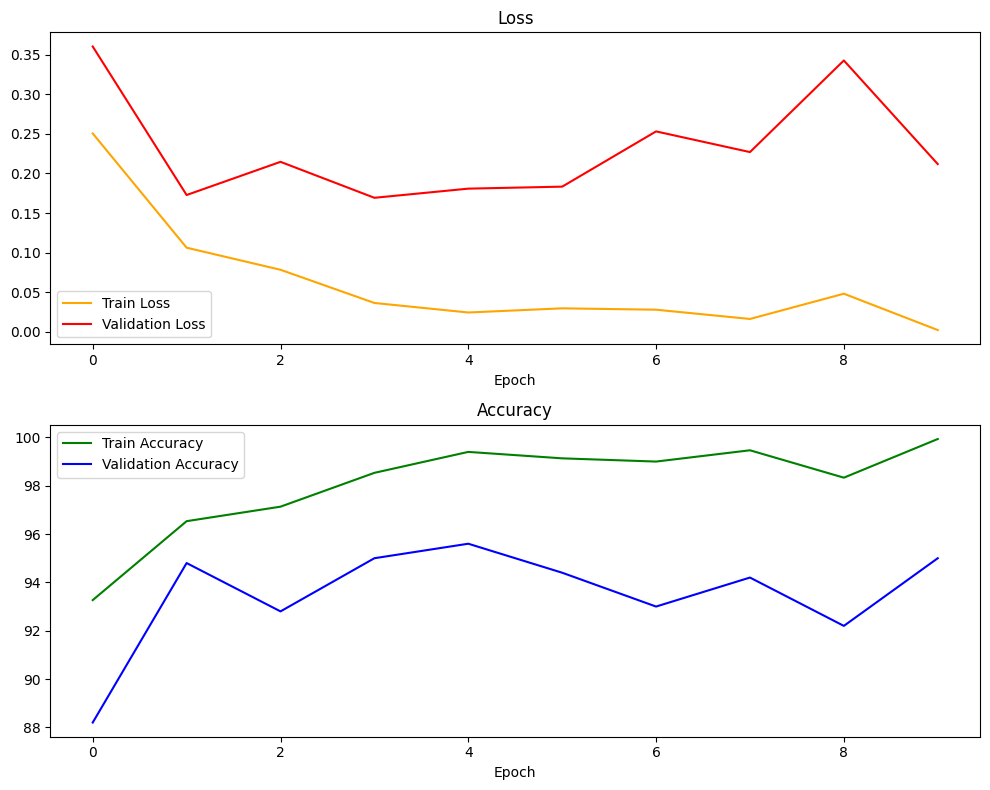

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Loss: train и validation
ax1.plot(train_losses, color='orange', label='Train Loss')
ax1.plot(losses, color='red', label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

# Accuracy: train и validation
ax2.plot(train_accuracies, color='green', label='Train Accuracy')
ax2.plot(accuracies, color='blue', label='Validation Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()


/var/folders/7w/24y7d8bx3s5_jm_zkqjh6bwm0000gn/T/ipykernel_61546/3937989968.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[oc, i, j] = np.sum(patch * self.weights[oc]) + self.biases[oc]


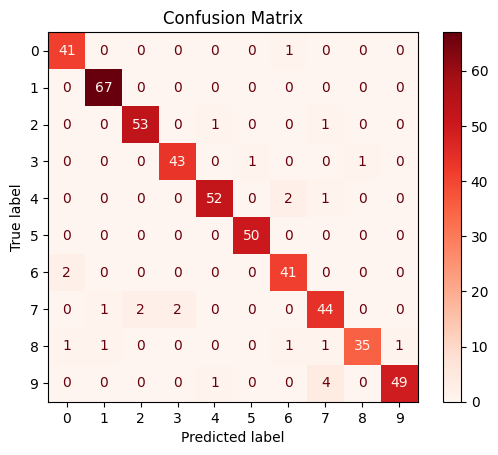

In [26]:
true_labels, pred_labels = [], []
for image, true in zip(test_X, test_y):
    pred = np.argmax(net.forward(image))
    pred_labels.append(pred)
    true_labels.append(true)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()